## Imports

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)
records.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [19]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

array([[<AxesSubplot:title={'center':'Time'}>,
        <AxesSubplot:title={'center':'V1'}>,
        <AxesSubplot:title={'center':'V2'}>,
        <AxesSubplot:title={'center':'V3'}>,
        <AxesSubplot:title={'center':'V4'}>,
        <AxesSubplot:title={'center':'V5'}>],
       [<AxesSubplot:title={'center':'V6'}>,
        <AxesSubplot:title={'center':'V7'}>,
        <AxesSubplot:title={'center':'V8'}>,
        <AxesSubplot:title={'center':'V9'}>,
        <AxesSubplot:title={'center':'V10'}>,
        <AxesSubplot:title={'center':'V11'}>],
       [<AxesSubplot:title={'center':'V12'}>,
        <AxesSubplot:title={'center':'V13'}>,
        <AxesSubplot:title={'center':'V14'}>,
        <AxesSubplot:title={'center':'V15'}>,
        <AxesSubplot:title={'center':'V16'}>,
        <AxesSubplot:title={'center':'V17'}>],
       [<AxesSubplot:title={'center':'V18'}>,
        <AxesSubplot:title={'center':'V19'}>,
        <AxesSubplot:title={'center':'V20'}>,
        <AxesSubplot:title={'center':'V

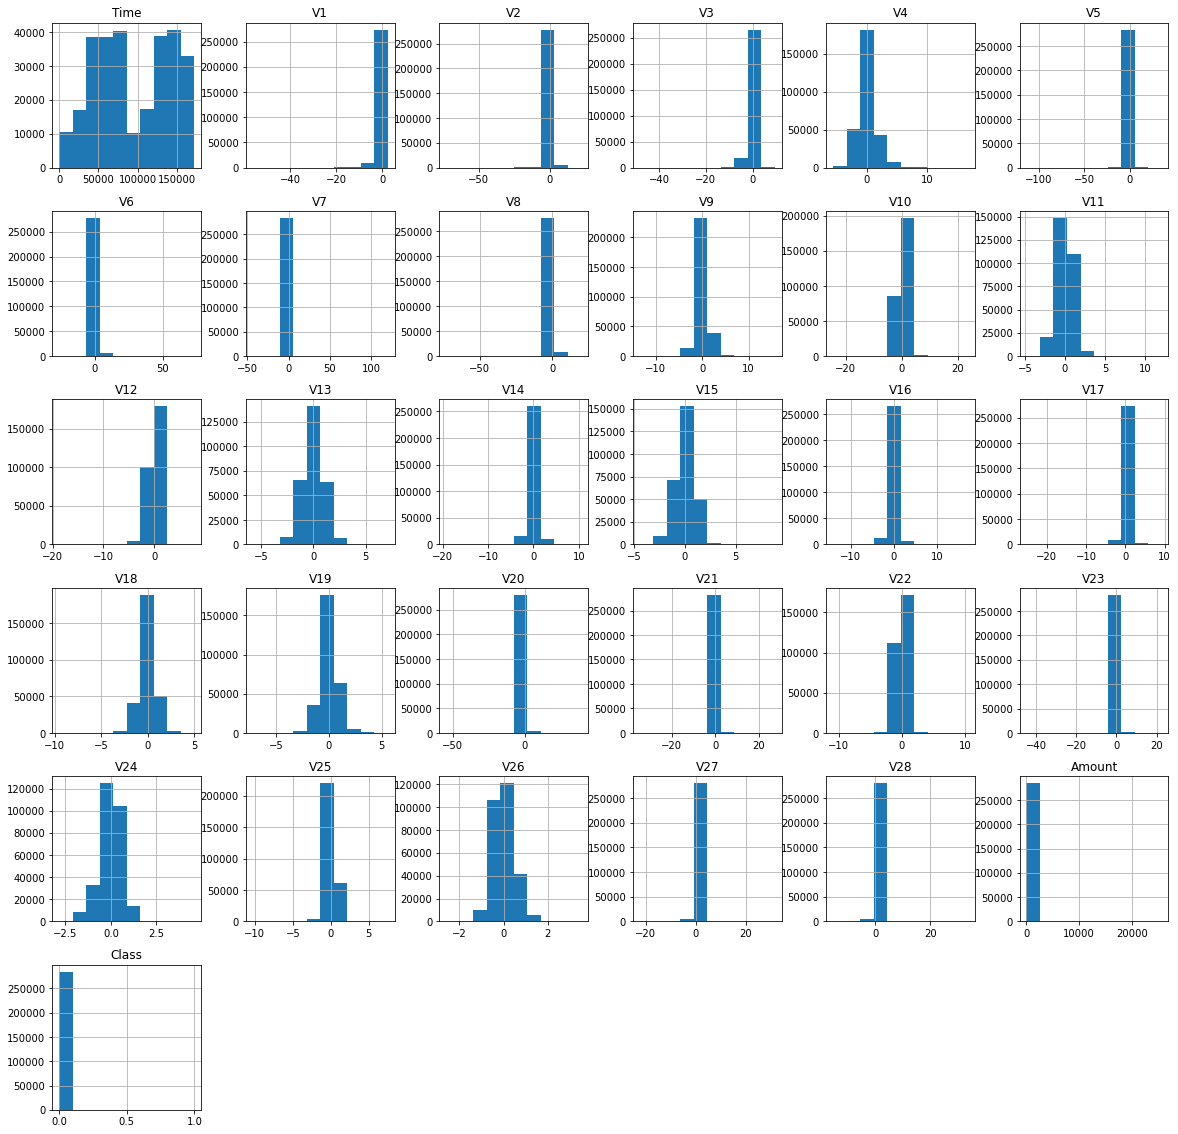

In [8]:
records.hist(figsize=(20,20))


## Normalize data